In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Working on new docking oracles.

In [2]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 30.0,
    'size_y': 30.0,
    'size_z': 30.0,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 11.5),
    acceptable=(7.125, 9.5)
)

# Create noisy evaluator
noisy_docking_oracle = NoisyOracle(
    docking_oracle,
    sigma=0.7
)

noisy_docking_utility = ClassicUtilityFunction(
    noisy_docking_oracle,
    ideal=(8.5, 9.5),
    acceptable=(7.125, 9.5)
)

Run experiment.

In [14]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = deck[10:15].update_annotations(),
    assays = [docking_utility.oracle.reset_cache()],
    budget = 400,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 2, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 2, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)

print(experiment.drug_env.assays['ADAM17 affinity'](experiment.drug_env.library)[0])
result = experiment.run(1, progress=True)

5.527120173687245


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

  0%|                                                                                           | 0/400 [00:00<?, ?it/s]

  4%|███▎                                                                              | 16/400 [00:00<00:04, 84.00it/s]

5.527120173687245




  6%|█████▎                                                                            | 26/400 [00:05<01:44,  3.59it/s]

  9%|███████▍                                                                          | 36/400 [00:11<02:24,  2.53it/s]

7.007585169362114
7.007585169362114


 32%|██████████████████████████▎                                                      | 130/400 [13:37<28:17,  6.29s/it]


 12%|█████████▍                                                                        | 46/400 [00:21<03:33,  1.65it/s]

7.007585169362114




 14%|███████████▍                                                                      | 56/400 [00:27<03:34,  1.61it/s]

7.085725980911122
7.085725980911122




 16%|████████████▉                                                                     | 63/400 [01:07<10:45,  1.92s/it]

7.085725980911122




 18%|██████████████▉                                                                   | 73/400 [01:16<08:25,  1.54s/it]

7.396581951773857
7.396581951773857




 19%|███████████████▌                                                                  | 76/400 [02:27<23:39,  4.38s/it]

7.396581951773857




 22%|█████████████████▋                                                                | 86/400 [02:34<15:47,  3.02s/it]

7.396581951773857
7.396581951773857




 23%|██████████████████▊                                                               | 92/400 [03:16<20:25,  3.98s/it]

7.396581951773857


  0%|                                                                                             | 0/1 [03:17<?, ?it/s]

KeyboardInterrupt



Visualizing affinity in chemical networks.

In [82]:
import networkx

affinity = []
G = nx.DiGraph()
for mol in drug_env.library:
    if mol.smiles not in G:
        G.add_node(mol.name)
        affinity.extend(docking_oracle([mol]))
    
        if mol.inspiration is not None:
            if mol.inspiration.name != mol.name:
                G.add_edge(mol.inspiration.name, mol.name)

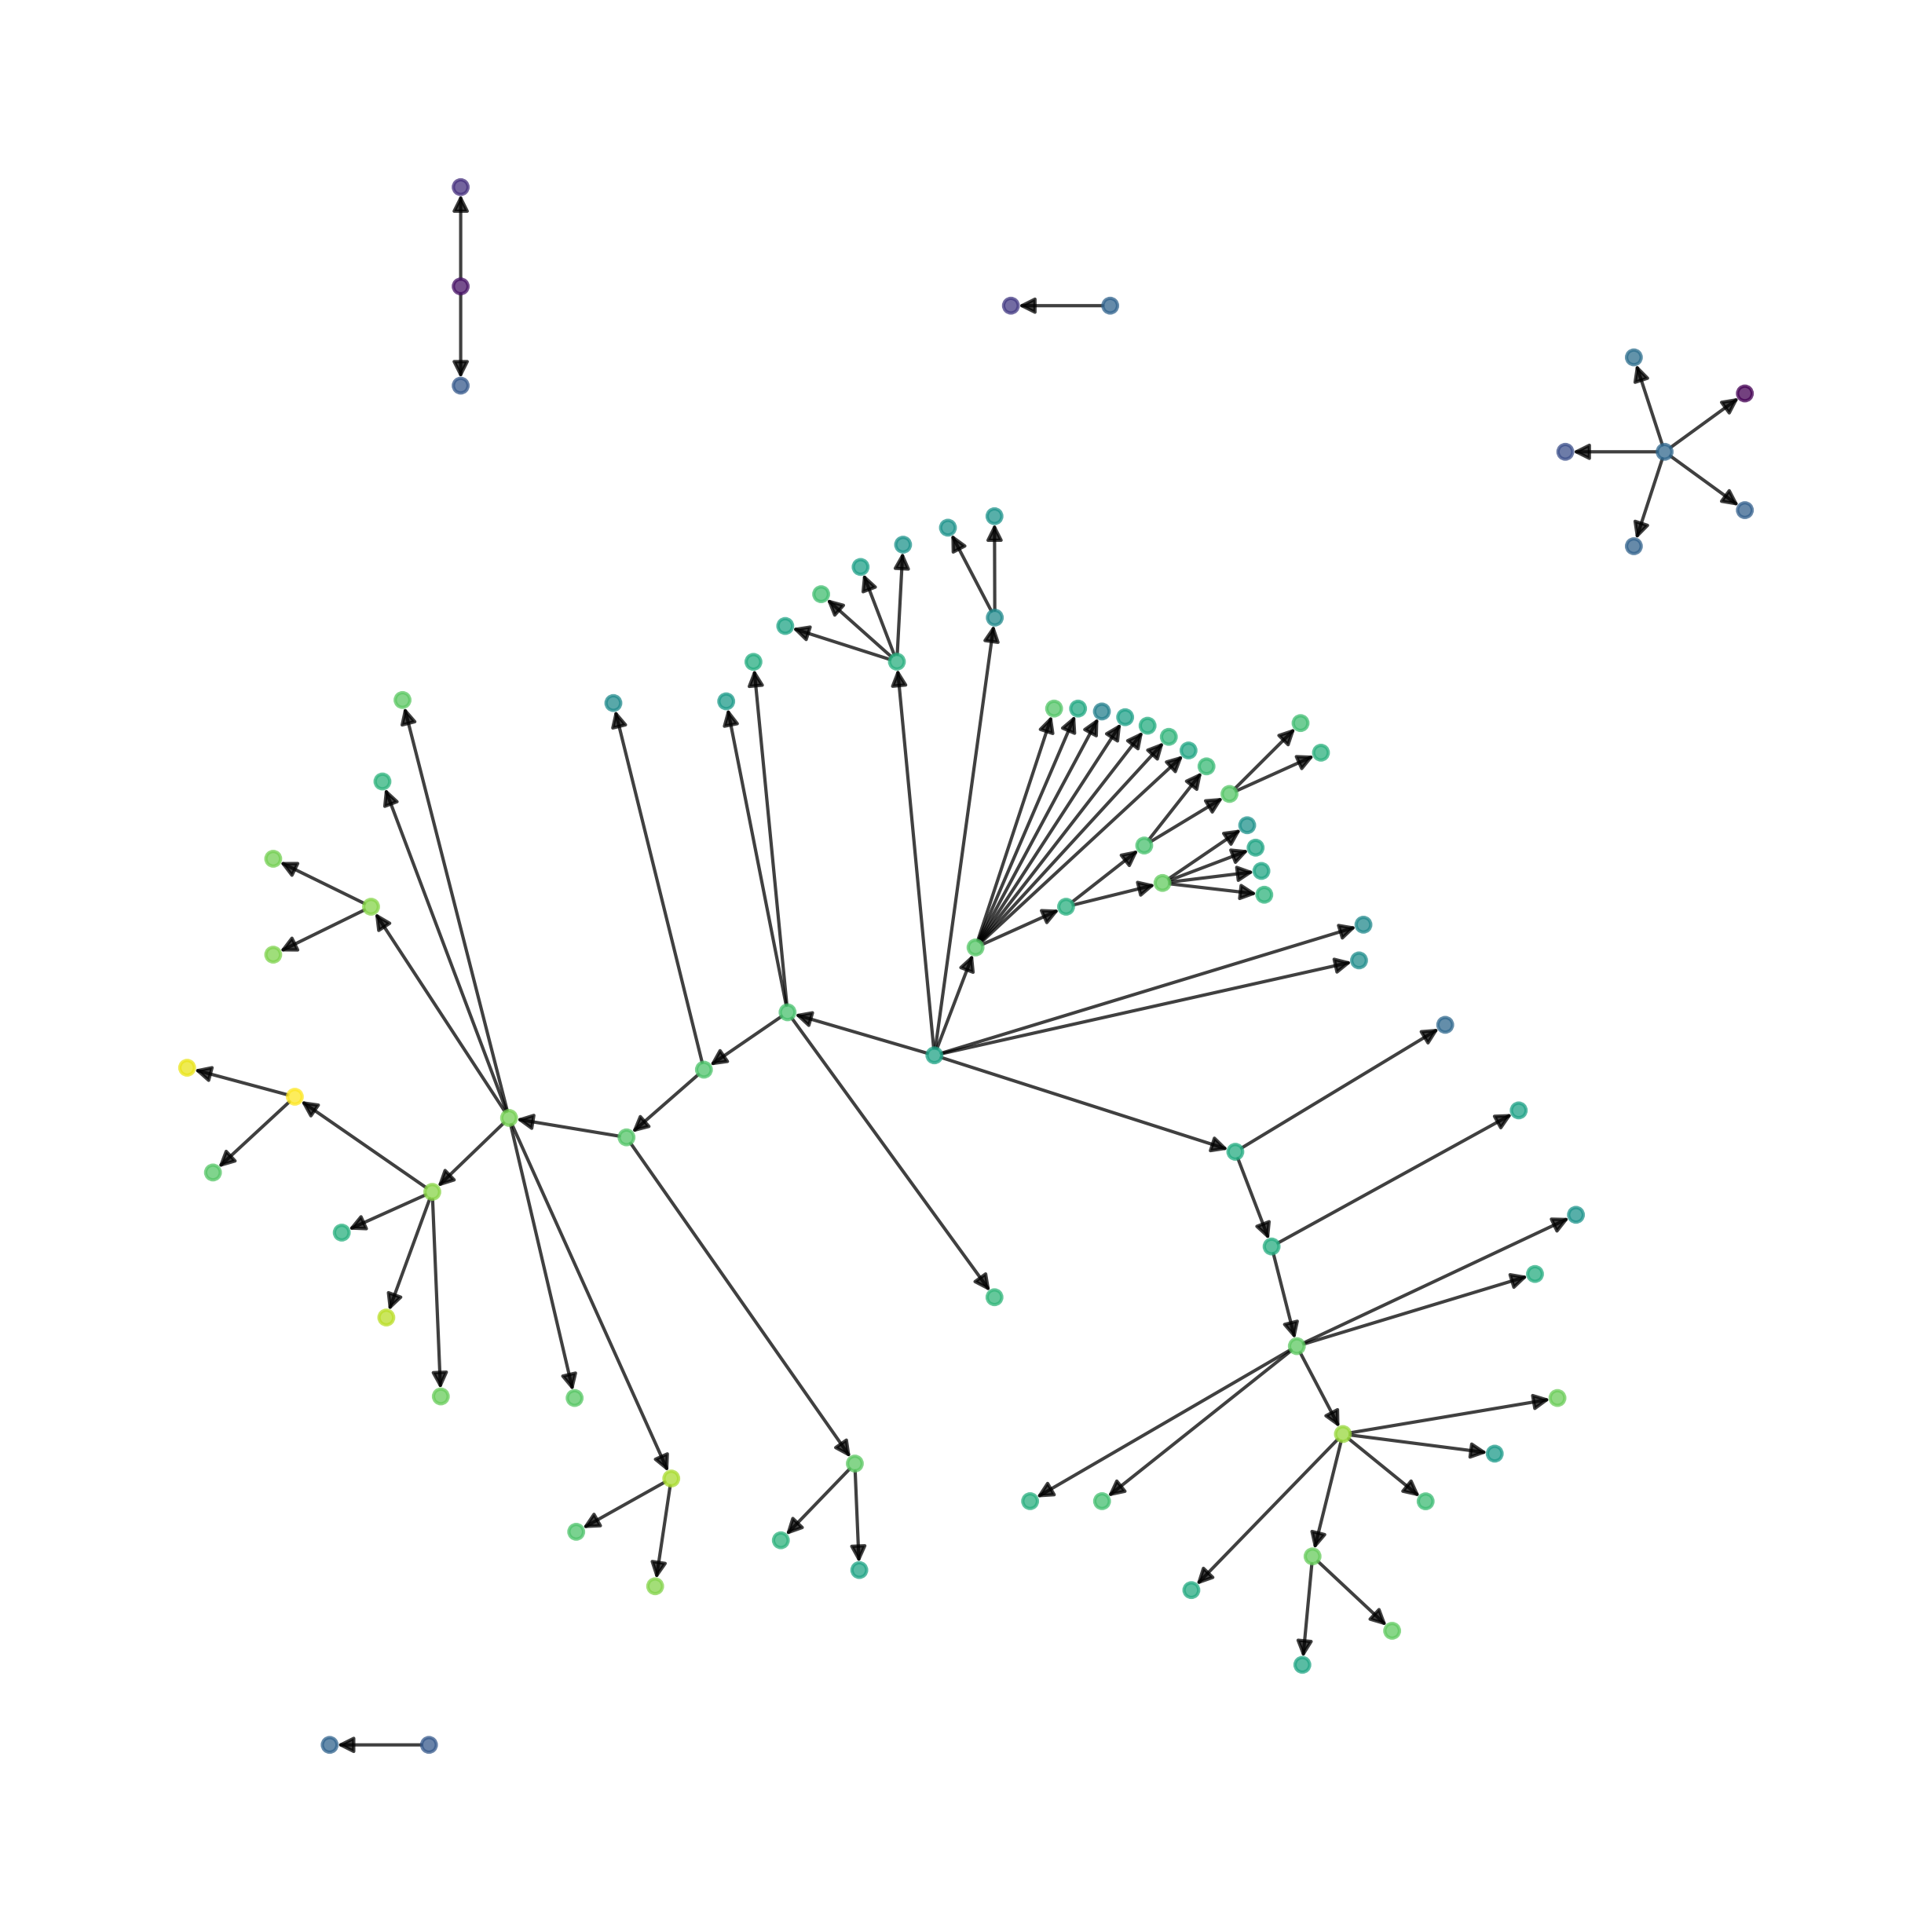

In [85]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8), dpi=300)
nx.draw(
    G,
    pos,
    node_size=20,
    alpha=0.75,
    node_color=affinity,
    with_labels=False
)
plt.axis("equal")
plt.show()